## Business Understanding

**Business Problem**: The company is experiencing customer churn, and they want to predict which customers are likely to leave so that proactive retention strategies can be applied.

**Goals**:
- Build a classification model to predict churn (True/False).
- Compare with a regression approach that predicts the probability or risk score of churn.
- Provide insights into what factors most influence customer churn and make actionable recommendations.

## Data Understanding

The dataset includes demographic, usage, and service-related information for 3,333 telecom customers.

Some key variables:
- `international plan` and `voice mail plan`: binary service options
- `total day/eve/night minutes` and related charges: usage data
- `customer service calls`: may be a sign of dissatisfaction
- `churn`: the target variable

I'll explore relationships and detect any issues (e.g. missing data, redundancy).


In [1]:
# Data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the dataset
df = pd.read_csv("churn-in-telecoms.csv")  

# Preview the data
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check for duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())

Missing values per column:
state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

Number of duplicate rows: 0


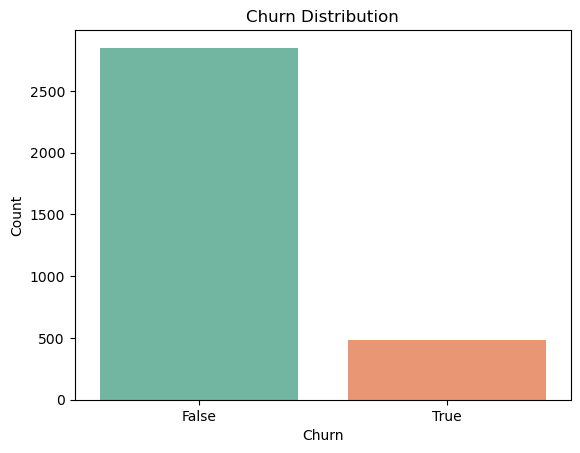

Churn Rate (%):
churn
False    85.508551
True     14.491449
Name: proportion, dtype: float64


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Class distribution
sns.countplot(data=df, x="churn", hue="churn", palette="Set2", legend=False)
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

# Class balance percentage
churn_rate = df["churn"].value_counts(normalize=True) * 100
print("Churn Rate (%):")
print(churn_rate)

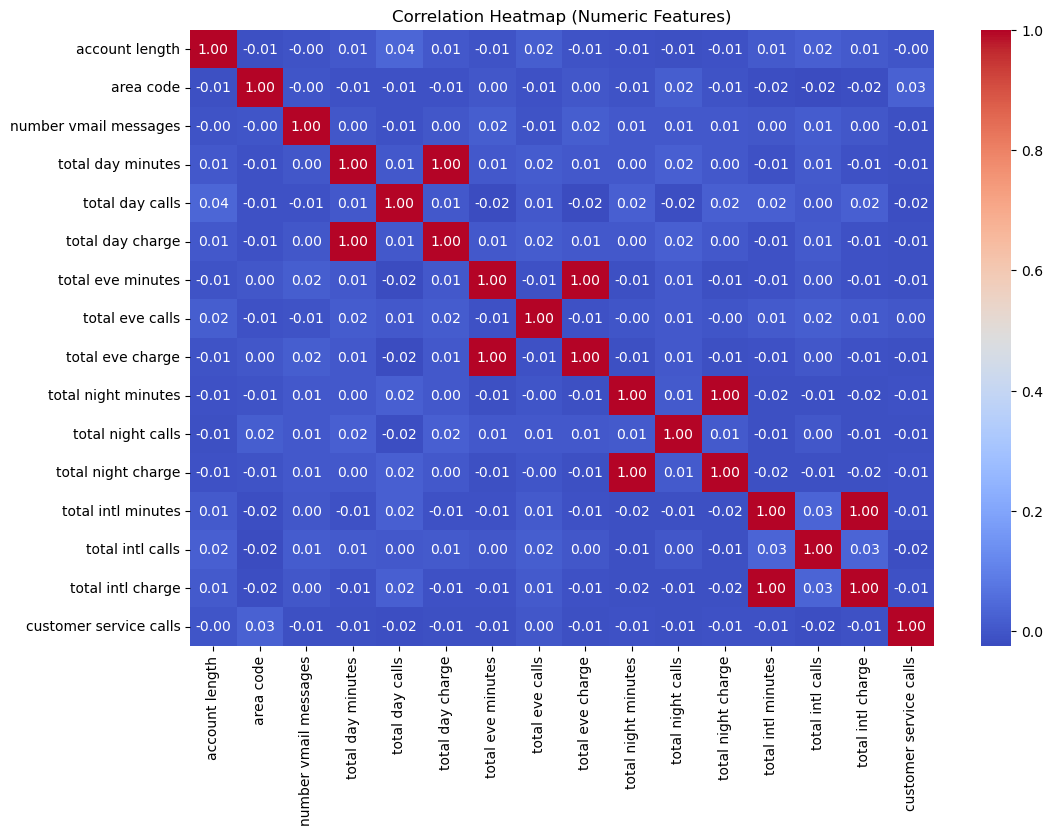

<Figure size 640x480 with 0 Axes>

In [5]:
# Only numeric columns
numeric_df = df.select_dtypes(include=["int64", "float64"])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight')

### Key Takeaway

The call durations (day, evening, night, international) are perfectly linearly related to their corresponding charges, which is expected.

## Encode Categorical Variables

In [6]:
# Encode target
df["churn"] = df["churn"].astype(int)

In [7]:
#Drop irrelevant columns
df_prep = df.drop(columns=["phone number"])

In [8]:
# Encode yes/no to 1/0
df_prep["international plan"] = df_prep["international plan"].map({"yes": 1, "no": 0})
df_prep["voice mail plan"] = df_prep["voice mail plan"].map({"yes": 1, "no": 0})

# encode 'state'
df_prep = pd.get_dummies(df_prep, columns=["state"], drop_first=True)

# Logistic Regression

## Train-Test Split

In [9]:
from sklearn.model_selection import train_test_split

X = df_prep.drop("churn", axis=1)
y = df_prep["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Feature Scaling

In [10]:
from sklearn.preprocessing import StandardScaler

# Identify numeric columns
numeric_cols = X.select_dtypes(include=["float64", "int64"]).columns

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])


## Fit Logistic Regression Baseline Model

In [11]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

## Evaluate Model Performance

Accuracy: 0.8605697151424287
ROC AUC Score: 0.8084463736661243

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       570
           1       0.54      0.26      0.35        97

    accuracy                           0.86       667
   macro avg       0.71      0.61      0.64       667
weighted avg       0.83      0.86      0.84       667



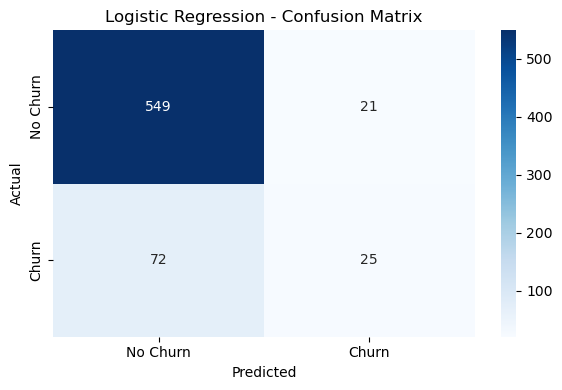

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## Logistic Regression – Interpretation

### Results Summary
- **Accuracy**: 86.1% — strong overall performance.
- **ROC AUC Score**: 0.81 — indicates good separation between churners and non-churners.
- **Recall for Churners (True)**: 26% — the model only caught about 1 in 4 actual churners.
- **Precision for Churners**: 54% — when it predicts a customer will churn, it’s correct just over half the time.

### Insights
- The model does very well identifying non-churners (96% recall), but misses many customers who actually churn.
- This can be risky for the business if those missed churners don’t get any intervention.
- Logistic regression is simple and interpretable but doesn't capture complex relationships or interactions in the data.

### Strengths
- Very stable and easy to explain.



## Decision Tree Model – Classification

## Train the Model

## Baseline Decision Tree Model
This version is the starting point for comparison.

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Baseline Decision Tree
baseline_dt = DecisionTreeClassifier(random_state=42)
baseline_dt.fit(X_train, y_train)

# Prediction  and evaluation
baseline_preds = baseline_dt.predict(X_test)
print("Baseline Accuracy:", accuracy_score(y_test, baseline_preds))
print(classification_report(y_test, baseline_preds))

Baseline Accuracy: 0.904047976011994
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       570
           1       0.68      0.64      0.66        97

    accuracy                           0.90       667
   macro avg       0.81      0.79      0.80       667
weighted avg       0.90      0.90      0.90       667



In [14]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5) 
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

## Tuned Decision  Tree Model (max_depth=5)
To reduce overfitting and improve performance, I have  tuned the model by limiting the tree depth.

In [15]:
# Tuned Decision Tree
tuned_dt = DecisionTreeClassifier(random_state=42, max_depth=5)
tuned_dt.fit(X_train, y_train)

# Predictions and evaluation
tuned_preds = tuned_dt.predict(X_test)
print("Tuned Accuracy:", accuracy_score(y_test, tuned_preds))
print(classification_report(y_test, tuned_preds))

Tuned Accuracy: 0.9175412293853074
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       570
           1       0.76      0.63      0.69        97

    accuracy                           0.92       667
   macro avg       0.85      0.80      0.82       667
weighted avg       0.91      0.92      0.91       667



## Evaluate the Model

Accuracy: 0.9175412293853074
ROC AUC Score: 0.814134563212154

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       570
           1       0.76      0.63      0.69        97

    accuracy                           0.92       667
   macro avg       0.85      0.80      0.82       667
weighted avg       0.91      0.92      0.91       667



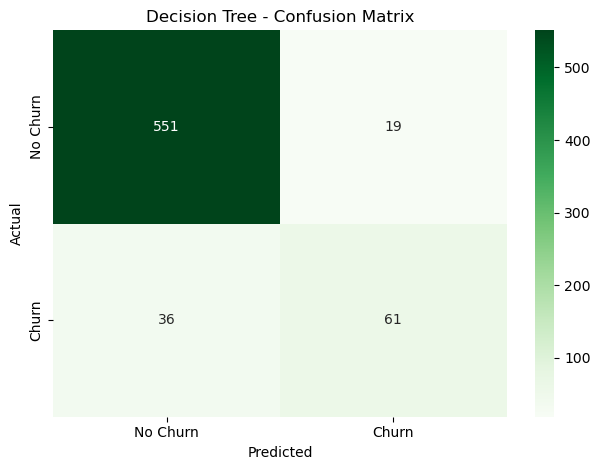

In [16]:
# Predictions
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

# Confusion Matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", cmap="Greens",
            xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## Interpretation

## Decision Tree Classification Model – Interpretation

### Results Summary
- **Accuracy**: 91.8% — very high overall accuracy.
- **ROC AUC**: 0.81 — good ability to separate churners from non-churners.
- **Recall for Churners (True)**: 63% — the model correctly identified 63% of actual churners.
- **Precision for Churners**: 76% — out of all customers predicted to churn, 76% truly did.

### Insights
- The model performs very well on non-churners (94% precision, 97% recall).
- Churners are harder to identify i.e. only 63% recall, but this is still stronger than baseline logistic regression.

### Strengths
- Easy to interpret with decision paths.
- Captures non-linear patterns and interactions between features.
- Reasonable recall for churners.

### Limitations
- Still misses some churners (false negatives).
- Can overfit if not carefully tuned.

### Business Recommendation
- Use this model to trigger retention actions for high-risk customers.
- Combine this with churn risk scores (from regression) to rank customers by urgency.


## Final Recommendations

- Use the Decision Tree Classifier for production churn prediction due to better recall and clear logic paths.
- Support with churn risk scores from regression for prioritizing interventions.
- Collect more data (e.g., customer complaints, service downtimes) to improve model accuracy.